<a href="https://colab.research.google.com/github/HillaAnku/HillaAnku/blob/master/Credit_Risk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Introduction**

Credit risk is the possibility that a borrower defaults on a debt or fails to make required payments. The rsik of default on debt payments is a source of great concern and loss of revenue to lenders. If not managed properly, borrower default could lead to major losses and expose lenders to grave financial dangers. Credit risk models seek to leverage data and build a model that predicts a borrower's riskiness based on their past borrowing behavior. The model predicts whether a borrower is likely to default or not.

In this notebook, I walk through the building of a credit risk model. This analysis spans three different notebooks because of the size of the data. In the first notebook, I analyze continous variables only and separately. The second notebook analyzes the categorical variables. The data used in this model is lending club borrower data which is publicly available on Kaggle. The dataset contains 2.2M+ rows.

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from sqlalchemy import create_engine
from sklearn import linear_model
import warnings
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, classification_report
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# load dataset

lendingclub_df = pd.read_csv('/content/drive/My Drive/python_for_data_scientists/lendingclub.csv')

I have processed, anlyzed and selected continous and categorical variables in separate notebooks. In this notebook, I put together all the selected variables (only those variables identified as useful predictors of loan default earlier in separate notebooks) and make a new dataframe. I process and clean these variables just to get them ready for model building.

Below is the list of selected continued and categorical variables.

In [0]:
# List of continous variables

cont_vars_selected = ['int_rate',
 'annual_inc',
 'dti',
 'delinq_2yrs',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'out_prncp_inv',
 'total_rec_int',
 'total_rec_late_fee',
 'collection_recovery_fee',
 'last_pymnt_amnt',
 'collections_12_mths_ex_med',
 'acc_now_delinq',
 'tot_coll_amt',
 'open_acc_6m',
 'open_act_il',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il',
 'total_bal_il',
 'il_util',
 'open_rv_12m',
 'open_rv_24m',
 'max_bal_bc',
 'all_util',
 'total_rev_hi_lim',
 'inq_fi',
 'total_cu_tl',
 'inq_last_12m',
 'acc_open_past_24mths',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'chargeoff_within_12_mths',
 'delinq_amnt',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mort_acc',
 'mths_since_recent_bc',
 'mths_since_recent_inq',
 'num_accts_ever_120_pd',
 'num_actv_bc_tl',
 'num_bc_sats',
 'num_bc_tl',
 'num_il_tl',
 'num_op_rev_tl',
 'num_rev_accts',
 'num_rev_tl_bal_gt_0',
 'num_tl_120dpd_2m',
 'num_tl_30dpd',
 'num_tl_90g_dpd_24m',
 'num_tl_op_past_12m',
 'pct_tl_nvr_dlq',
 'percent_bc_gt_75',
 'pub_rec_bankruptcies',
 'tax_liens',
 'tot_hi_cred_lim',
 'total_bal_ex_mort',
 'total_bc_limit',
 'total_il_high_credit_limit']

In [0]:
# Make a dataframe of continous variables using the list of selected continous variables

cont_vars_df = lendingclub_df[cont_vars_selected]

In [0]:
# List of selected categorical variables

selected_cat_vars = ['debt_settlement_flag', 'grade', 'loan_status', 'home_ownership', 'issue_d', 'emp_length', 'earliest_cr_line', 'term']

In [0]:
# Make a dataframe of selected categorical variables

cat_vars_df = lendingclub_df[selected_cat_vars]

In [0]:
# Concatenate continous variables dataframe and categorical variables dataframe. the resulting dataframe is contains all
# the variables that will be processed and used in building the credit risk model.

model_data = pd.concat([cont_vars_df, cat_vars_df], axis = 1)

In [0]:
# Quick view model data

model_data.head()

,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp_inv,total_rec_int,total_rec_late_fee,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,debt_settlement_flag,grade,loan_status,home_ownership,issue_d,emp_length,earliest_cr_line,term
0,13.56,55000.0,18.24,0.0,1.0,NaN,9.0,1.0,4341,10.3,34.0,2386.02,53.04,0.0,0.0,84.92,0.0,0.0,0.0,2.0,2.0,1.0,2.0,2.0,12560.0,69.0,2.0,7.0,2137.0,28.0,42000.0,1.0,11.0,2.0,9.0,1878.0,34360.0,5.9,0.0,0.0,140.0,212.0,1.0,1.0,0.0,1.0,2.0,0.0,2.0,3.0,3.0,16.0,7.0,18.0,5.0,0.0,0.0,0.0,3.0,100.0,0.0,1.0,0.0,60124.0,16901.0,36500.0,18124.0,N,C,Current,RENT,Dec-2018,10+ years,Apr-2001,36 months
1,18.94,90000.0,26.52,0.0,0.0,71.0,13.0,1.0,12315,24.2,44.0,29387.75,894.86,0.0,0.0,777.23,0.0,0.0,1208.0,4.0,4.0,2.0,3.0,3.0,87153.0,88.0,4.0,5.0,998.0,57.0,50800.0,2.0,15.0,2.0,10.0,24763.0,13761.0,8.3,0.0,0.0,163.0,378.0,4.0,3.0,3.0,4.0,4.0,0.0,2.0,4.0,9.0,27.0,8.0,14.0,4.0,0.0,0.0,0.0,6.0,95.0,0.0,1.0,0.0,372872.0,99468.0,15000.0,94072.0,N,D,Current,MORTGAGE,Dec-2018,10+ years,Jun-1987,60 months
2,17.97,59280.0,10.51,0.0,0.0,NaN,8.0,0.0,4599,19.1,13.0,4787.21,141.10,0.0,0.0,180.69,0.0,0.0,0.0,0.0,1.0,0.0,2.0,14.0,7150.0,72.0,0.0,2.0,0.0,35.0,24100.0,1.0,5.0,0.0,4.0,18383.0,13800.0,0.0,0.0,0.0,87.0,92.0,15.0,14.0,2.0,77.0,14.0,0.0,0.0,3.0,3.0,4.0,6.0,7.0,3.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,136927.0,11749.0,13800.0,10000.0,N,D,Current,MORTGAGE,Dec-2018,6 years,Apr-2011,36 months
3,18.94,92000.0,16.74,0.0,0.0,NaN,10.0,0.0,5468,78.1,13.0,3831.93,118.64,0.0,0.0,146.51,0.0,0.0,686.0,1.0,5.0,3.0,5.0,5.0,30683.0,68.0,0.0,0.0,3761.0,70.0,7000.0,2.0,4.0,3.0,5.0,30505.0,1239.0,75.2,0.0,0.0,62.0,154.0,64.0,5.0,3.0,64.0,5.0,0.0,1.0,1.0,2.0,7.0,2.0,3.0,2.0,0.0,0.0,0.0,3.0,100.0,100.0,0.0,0.0,385183.0,36151.0,5000.0,44984.0,N,D,Current,MORTGAGE,Dec-2018,10+ years,Feb-2006,36 months
4,16.14,57250.0,26.35,0.0,0.0,NaN,12.0,0.0,829,3.6,26.0,29339.02,762.23,0.0,0.0,731.78,0.0,0.0,0.0,3.0,5.0,3.0,5.0,4.0,28845.0,89.0,2.0,4.0,516.0,54.0,23100.0,1.0,0.0,0.0,9.0,9667.0,8471.0,8.9,0.0,0.0,53.0,216.0,2.0,2.0,2.0,2.0,13.0,0.0,2.0,3.0,8.0,9.0,6.0,15.0,2.0,0.0,0.0,0.0,5.0,92.3,0.0,0.0,0.0,157548.0,29674.0,9300.0,32332.0,N,C,Current,MORTGAGE,Dec-2018,10+ years,Dec-2000,60 months


The following lines are for cleaning up some variables, renaming and stripping off unwabted spaces and characters.

In [0]:
# Strip unwanted string characers from emp_length column

model_data['emp_length_int'] = model_data['emp_length'].str.replace(' years', '')
model_data['emp_length_int'] = model_data['emp_length_int'].str.replace('< 1 year', str(0))
model_data['emp_length_int'] = model_data['emp_length_int'].str.replace('1 year', str(1))
model_data['emp_length_int'] = model_data['emp_length_int'].str.replace('10\+', '10')

In [0]:
# convert emp_length_int(categorical) to numerical data

model_data['emp_length_int'] = pd.to_numeric(model_data['emp_length_int'])

In [0]:
# Strip unwanted string characters from the 'term' variable

model_data['term_int'] = model_data['term'].str.replace(' ', '')
model_data['term_int'] = model_data['term_int'].str.replace('months', '')

In [0]:
# convert the categorical variable 'term_int' to a numerical one

model_data['term_int'] = pd.to_numeric(model_data['term_int'])

The next few lines processes some date columns stored as string types. I convert them to datetime and then convert the datetime formats to numerical columns. This way, these variables can assume their appropriate number types and be included in the probability of default model. 

In [0]:
# Convert the string type issue_d to datetime

model_data['_since_issue_d'] = pd.to_datetime(model_data['issue_d'])

In [0]:
# Convert 'months_since_loan_issue' to number of months and rename the column

model_data['mths_since_loan_issue'] = round(pd.to_numeric((pd.to_datetime('2020-04-18') - model_data['_since_issue_d'])/np.timedelta64(1, 'M')))

In [0]:
# earliest_cr_line is stored date stored as a string, convert it to datetime

model_data['tm_of_earliestcr'] = pd.to_datetime(model_data['earliest_cr_line'])

In [0]:
# Instead showing the time in days, convert to number of months

model_data['mths_since_earliest_cr'] = round(pd.to_numeric((pd.to_datetime('2019-03-18') - model_data['tm_of_earliestcr'])/np.timedelta64(1, 'M')))

I encode the target variable into a binary. 'Charged Off, Default, Late (16-30 days) and Does not meet the credit policy. Status: Charged Off' in the loan status column will all take a value of 0 while everything else takes the value 1. Zero here stands for bad_loan(default) while one stands for good_loan(non-default). The target variable is named good_bad in the dataset.

In [0]:
model_data['good_bad'] = np.where(model_data['loan_status'].isin(['Charged Off', 'Default', 
                                                                   'Late (16-30 days)',
                                                                   'Does not meet the credit policy. Status:Charged Off',
                                                                   ]), 0, 1)

In [0]:
model_data.groupby('good_bad').count()

,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp_inv,total_rec_int,total_rec_late_fee,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,...,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,debt_settlement_flag,grade,loan_status,home_ownership,issue_d,emp_length,earliest_cr_line,term,emp_length_int,term_int,_since_issue_d,mths_since_loan_issue,tm_of_earliestcr,mths_since_earliest_cr
good_bad,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,266184,266184,266114,266181,266181,136766,266181,266181,266184,266000,266181,266184,266184,266184,266184,266184,266156,266181,255105,117236,117236,117236,117236,113572,117236,102479,117236,117236,117236,117227,255105,117236,117236,117236,258537,255099,255627,255461,266156,266181,...,255104,255104,255105,258537,255829,239770,255105,255105,257159,255105,255105,255105,255105,255105,241735,255105,255105,255105,255083,255551,265850,266173,255105,258537,258537,255105,266184,266184,266184,266184,266184,245341,266181,266184,245341,266184,266184,266184,266181,266181
1,1994484,1994480,1992843,1994458,1994457,965400,1994458,1994458,1994484,1992866,1994458,1994484,1994484,1994484,1994484,1994484,1994367,1994458,1935287,1277302,1277303,1277303,1277303,1237172,1277303,1089339,1277303,1277303,1277303,1277093,1935287,1277303,1277302,1277302,1952101,1935223,1930106,1929136,1994367,1994458,...,1935287,1935287,1935287,1952101,1931427,1725463,1935287,1935287,1944919,1935287,1935287,1935287,1935286,1935287,1865276,1935287,1935287,1935287,1935154,1929738,1993453,1994390,1935287,1952101,1952101,1935287,1994484,1994484,1994484,1994484,1994484,1868420,1994458,1994484,1868420,1994484,1994484,1994484,1994458,1994458


In [0]:
# Drop the processed date variables together with their intermediate step datetime columns and the loan status column
# The resultant dataset is ready for further analysis and subsequent modeling

model_data = model_data.drop(['emp_length', 'issue_d', 'earliest_cr_line', 'term', '_since_issue_d', 'tm_of_earliestcr', 'loan_status'], axis = 1)

In [0]:
pd.set_option('display.max_rows', None)

In [0]:
# check for missing values

model_data.isnull().sum()*100/model_data.isnull().count()

int_rate                       0.000000
annual_inc                     0.000177
dti                            0.075686
delinq_2yrs                    0.001283
inq_last_6mths                 0.001327
mths_since_last_delinq        51.246003
open_acc                       0.001283
pub_rec                        0.001283
revol_bal                      0.000000
revol_util                     0.079711
total_acc                      0.001283
out_prncp_inv                  0.000000
total_rec_int                  0.000000
total_rec_late_fee             0.000000
collection_recovery_fee        0.000000
last_pymnt_amnt                0.000000
collections_12_mths_ex_med     0.006414
acc_now_delinq                 0.001283
tot_coll_amt                   3.108639
open_acc_6m                   38.313012
open_act_il                   38.312968
open_il_12m                   38.312968
open_il_24m                   38.312968
mths_since_rcnt_il            40.250227
total_bal_il                  38.312968


In [0]:
# drop_missing_values

There are a lot of missing values in the data. I deal with this by replacing all missing values with the mean of that column leaving the categorical variables to be hot encoded.

In [0]:
# Fill missing values in each column with the mean of that column

for column_name in model_data.columns:
  if model_data[column_name].dtype != 'object':
    model_data[column_name].fillna(model_data[column_name].mean(), inplace = True)

In [0]:
# check for missing values

model_data.isnull().sum()*100/model_data.isnull().count()

int_rate                      0.0
annual_inc                    0.0
dti                           0.0
delinq_2yrs                   0.0
inq_last_6mths                0.0
mths_since_last_delinq        0.0
open_acc                      0.0
pub_rec                       0.0
revol_bal                     0.0
revol_util                    0.0
total_acc                     0.0
out_prncp_inv                 0.0
total_rec_int                 0.0
total_rec_late_fee            0.0
collection_recovery_fee       0.0
last_pymnt_amnt               0.0
collections_12_mths_ex_med    0.0
acc_now_delinq                0.0
tot_coll_amt                  0.0
open_acc_6m                   0.0
open_act_il                   0.0
open_il_12m                   0.0
open_il_24m                   0.0
mths_since_rcnt_il            0.0
total_bal_il                  0.0
il_util                       0.0
open_rv_12m                   0.0
open_rv_24m                   0.0
max_bal_bc                    0.0
all_util      

In [0]:
# There aren't any more missing values, I proceed to hot encode categorical variables and drop first

df = None
for column_name in model_data.columns:
    if model_data[column_name].dtype == 'object':
        df = pd.concat([df, pd.get_dummies(model_data[column_name], prefix = 1, prefix_sep = ':', drop_first = True)], axis = 1)

In [0]:
# merge the hot encoded variables back to model_data dataframe

model_data1 = pd.concat([df, model_data], axis = 1)

Quick view to ensure everything looks right in the data and proceed to drop categorical variables keeping only their hot encoded versions.

In [0]:
model_data1.head()

,1:Y,1:B,1:C,1:D,1:E,1:F,1:G,1:MORTGAGE,1:NONE,1:OTHER,1:OWN,1:RENT,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp_inv,total_rec_int,total_rec_late_fee,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,...,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,debt_settlement_flag,grade,home_ownership,emp_length_int,term_int,mths_since_loan_issue,mths_since_earliest_cr,good_bad
0,0,0,1,0,0,0,0,0,0,0,0,1,13.56,55000.0,18.24,0.0,1.0,34.540916,9.0,1.0,4341,10.3,34.0,2386.02,53.04,0.0,0.0,84.92,0.0,0.0,0.0,2.0,2.0,1.0,2.0,2.0,12560.0,69.0,2.0,7.0,...,1878.0,34360.0,5.9,0.0,0.0,140.0,212.0,1.0,1.0,0.0,1.0,2.0,0.0,2.0,3.0,3.0,16.0,7.0,18.0,5.0,0.0,0.0,0.0,3.0,100.0,0.0,1.0,0.0,60124.0,16901.0,36500.0,18124.0,N,C,RENT,10.0,36,17.0,216.0,1
1,0,0,0,1,0,0,0,1,0,0,0,0,18.94,90000.0,26.52,0.0,0.0,71.000000,13.0,1.0,12315,24.2,44.0,29387.75,894.86,0.0,0.0,777.23,0.0,0.0,1208.0,4.0,4.0,2.0,3.0,3.0,87153.0,88.0,4.0,5.0,...,24763.0,13761.0,8.3,0.0,0.0,163.0,378.0,4.0,3.0,3.0,4.0,4.0,0.0,2.0,4.0,9.0,27.0,8.0,14.0,4.0,0.0,0.0,0.0,6.0,95.0,0.0,1.0,0.0,372872.0,99468.0,15000.0,94072.0,N,D,MORTGAGE,10.0,60,17.0,382.0,1
2,0,0,0,1,0,0,0,1,0,0,0,0,17.97,59280.0,10.51,0.0,0.0,34.540916,8.0,0.0,4599,19.1,13.0,4787.21,141.10,0.0,0.0,180.69,0.0,0.0,0.0,0.0,1.0,0.0,2.0,14.0,7150.0,72.0,0.0,2.0,...,18383.0,13800.0,0.0,0.0,0.0,87.0,92.0,15.0,14.0,2.0,77.0,14.0,0.0,0.0,3.0,3.0,4.0,6.0,7.0,3.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,136927.0,11749.0,13800.0,10000.0,N,D,MORTGAGE,6.0,36,17.0,96.0,1
3,0,0,0,1,0,0,0,1,0,0,0,0,18.94,92000.0,16.74,0.0,0.0,34.540916,10.0,0.0,5468,78.1,13.0,3831.93,118.64,0.0,0.0,146.51,0.0,0.0,686.0,1.0,5.0,3.0,5.0,5.0,30683.0,68.0,0.0,0.0,...,30505.0,1239.0,75.2,0.0,0.0,62.0,154.0,64.0,5.0,3.0,64.0,5.0,0.0,1.0,1.0,2.0,7.0,2.0,3.0,2.0,0.0,0.0,0.0,3.0,100.0,100.0,0.0,0.0,385183.0,36151.0,5000.0,44984.0,N,D,MORTGAGE,10.0,36,17.0,157.0,1
4,0,0,1,0,0,0,0,1,0,0,0,0,16.14,57250.0,26.35,0.0,0.0,34.540916,12.0,0.0,829,3.6,26.0,29339.02,762.23,0.0,0.0,731.78,0.0,0.0,0.0,3.0,5.0,3.0,5.0,4.0,28845.0,89.0,2.0,4.0,...,9667.0,8471.0,8.9,0.0,0.0,53.0,216.0,2.0,2.0,2.0,2.0,13.0,0.0,2.0,3.0,8.0,9.0,6.0,15.0,2.0,0.0,0.0,0.0,5.0,92.3,0.0,0.0,0.0,157548.0,29674.0,9300.0,32332.0,N,C,MORTGAGE,10.0,60,17.0,220.0,1


In [0]:
# make a list of all categorical variables

dtype_obj_uniquevalues_dict = {}
for column_name in model_data1.columns:
    if model_data1[column_name].dtype == 'object':
      dtype_obj_uniquevalues_dict[column_name] = model_data1[column_name].nunique()

In [0]:
dtype_obj_uniquevalues_dict

{'debt_settlement_flag': 2, 'grade': 7, 'home_ownership': 6}

In [0]:
# drop categorical variables, their hot encoded versions will be used in the model

model_data1.drop(['debt_settlement_flag', 'grade', 'home_ownership'], axis = 1, inplace = True)

In [0]:
model_data1.head()

,1:Y,1:B,1:C,1:D,1:E,1:F,1:G,1:MORTGAGE,1:NONE,1:OTHER,1:OWN,1:RENT,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp_inv,total_rec_int,total_rec_late_fee,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,...,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,emp_length_int,term_int,mths_since_loan_issue,mths_since_earliest_cr,good_bad
0,0,0,1,0,0,0,0,0,0,0,0,1,13.56,55000.0,18.24,0.0,1.0,34.540916,9.0,1.0,4341,10.3,34.0,2386.02,53.04,0.0,0.0,84.92,0.0,0.0,0.0,2.0,2.0,1.0,2.0,2.0,12560.0,69.0,2.0,7.0,...,11.0,2.0,9.0,1878.0,34360.0,5.9,0.0,0.0,140.0,212.0,1.0,1.0,0.0,1.0,2.0,0.0,2.0,3.0,3.0,16.0,7.0,18.0,5.0,0.0,0.0,0.0,3.0,100.0,0.0,1.0,0.0,60124.0,16901.0,36500.0,18124.0,10.0,36,17.0,216.0,1
1,0,0,0,1,0,0,0,1,0,0,0,0,18.94,90000.0,26.52,0.0,0.0,71.000000,13.0,1.0,12315,24.2,44.0,29387.75,894.86,0.0,0.0,777.23,0.0,0.0,1208.0,4.0,4.0,2.0,3.0,3.0,87153.0,88.0,4.0,5.0,...,15.0,2.0,10.0,24763.0,13761.0,8.3,0.0,0.0,163.0,378.0,4.0,3.0,3.0,4.0,4.0,0.0,2.0,4.0,9.0,27.0,8.0,14.0,4.0,0.0,0.0,0.0,6.0,95.0,0.0,1.0,0.0,372872.0,99468.0,15000.0,94072.0,10.0,60,17.0,382.0,1
2,0,0,0,1,0,0,0,1,0,0,0,0,17.97,59280.0,10.51,0.0,0.0,34.540916,8.0,0.0,4599,19.1,13.0,4787.21,141.10,0.0,0.0,180.69,0.0,0.0,0.0,0.0,1.0,0.0,2.0,14.0,7150.0,72.0,0.0,2.0,...,5.0,0.0,4.0,18383.0,13800.0,0.0,0.0,0.0,87.0,92.0,15.0,14.0,2.0,77.0,14.0,0.0,0.0,3.0,3.0,4.0,6.0,7.0,3.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,136927.0,11749.0,13800.0,10000.0,6.0,36,17.0,96.0,1
3,0,0,0,1,0,0,0,1,0,0,0,0,18.94,92000.0,16.74,0.0,0.0,34.540916,10.0,0.0,5468,78.1,13.0,3831.93,118.64,0.0,0.0,146.51,0.0,0.0,686.0,1.0,5.0,3.0,5.0,5.0,30683.0,68.0,0.0,0.0,...,4.0,3.0,5.0,30505.0,1239.0,75.2,0.0,0.0,62.0,154.0,64.0,5.0,3.0,64.0,5.0,0.0,1.0,1.0,2.0,7.0,2.0,3.0,2.0,0.0,0.0,0.0,3.0,100.0,100.0,0.0,0.0,385183.0,36151.0,5000.0,44984.0,10.0,36,17.0,157.0,1
4,0,0,1,0,0,0,0,1,0,0,0,0,16.14,57250.0,26.35,0.0,0.0,34.540916,12.0,0.0,829,3.6,26.0,29339.02,762.23,0.0,0.0,731.78,0.0,0.0,0.0,3.0,5.0,3.0,5.0,4.0,28845.0,89.0,2.0,4.0,...,0.0,0.0,9.0,9667.0,8471.0,8.9,0.0,0.0,53.0,216.0,2.0,2.0,2.0,2.0,13.0,0.0,2.0,3.0,8.0,9.0,6.0,15.0,2.0,0.0,0.0,0.0,5.0,92.3,0.0,0.0,0.0,157548.0,29674.0,9300.0,32332.0,10.0,60,17.0,220.0,1


The data is now ready for model building. I split up the data into train and test sets setting a train size of 80% and test size of 20%. All Models are trained on the train set and tested on the test set. 

In [0]:
# Declare feature set and target set

X = model_data1.drop('good_bad', axis = 1)
Y = model_data1['good_bad']

In [0]:
# Split the data into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 400)

The first model here is trained with a logistic regression from sklearn and cross validated with five folds. This first model's main purpose is to have general view of how the selected variables are performing as far as predicting the target variable.

In [0]:
# Train first model using logistic regression

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train, y_train)
cv_scores = cross_val_score(lr, X_train, y_train, cv = 5)

print('Accuracy scores for the 5 folds: ', cv_scores)
print('Mean cross validatiion score: {:.3f}'.format(np.mean(cv_scores)))

Accuracy scores for the 5 folds:  [0.88250988 0.88088425 0.8815616  0.88092296 0.88337213]
Mean cross validatiion score: 0.882


In [0]:
# Accuracy score on train set

lr.score(X_train, y_train)

0.8825861167111041

In [0]:
# Accuracy score on test set

lr.score(X_test, y_test)

0.8832846014677065

In [0]:
# Get precision score

y_pred = lr.predict(X_test)
precision_score(y_test, y_pred)

0.8942521775159245

In [0]:
# Get recall score

recall_score(y_test,y_pred)

0.9841655997654906

From the results and based on the accuracy, precision and recall scores, I conclude that the selected variables are predicting the target well enough. These scores also show that the model is not overfitting. Infact, the model learns very well. Next, I check the confusion matrix.

In [0]:
# Confusion Matrix

from sklearn.metrics import confusion_matrix

predictions = lr.predict(X_test)

confusion = confusion_matrix(y_test, predictions, labels=[1, 0])
print(confusion)

[[392811   6320]
 [ 46451   6552]]


Even though the model is predicting well and with a high degree of accuracy, there is still some room for improvement because the model seems to be making too many false positive errors. Out of 53003 defaults/bad loans, the model is only predicting 6552 of them correctly while wrongly predicting 46451. This is of some concern. I train another model below to correct this problem. This time, I train the model using an ensemble random forest.

In [0]:
pd.options.display.max_rows = None

In [0]:
# Train the model using an ensemble method

from sklearn import ensemble

rf = ensemble.RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
# Get accuracy score on train set

rf.score(X_train, y_train)

0.9999972353298306

In [0]:
# Get accuracy score on test set

rf_predictions = rf.predict(X_test)
rf.score(X_test, y_test)

0.9764560948745283

In [0]:
# Get precision score

y_pred = rf.predict(X_test)
precision_score(y_test, y_pred)

0.9776709963948987

In [0]:
# Get recall score

recall_score(y_test,y_pred)

0.9960789815874989

In [0]:
# Confusion Matrix

from sklearn.metrics import confusion_matrix

# predictions = rf.predict(X_test)

confusion = confusion_matrix(y_test, rf_predictions, labels=[1, 0])
print(confusion)

[[397566   1565]
 [  9080  43923]]


With the ensemble random forest model, there is no overfitting and the model is learning very well evidenced in the performance metrics outlined above. Moreover, the predictive ability of the model improved significantly from about 88% accuracy to about 98%. Both precision and recall scores also improved. Most importantly, the number of false positive errors is greatly minimzed from 46451 down to 9134 which is a great improvement over the logistic regression model.

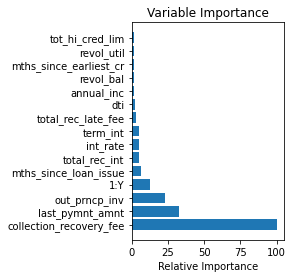

In [0]:
feature_importance = rf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(15) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx][::-1][0:15], align = 'center')
plt.yticks(pos, X.columns[sorted_idx][::-1][0:15])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

To access the impact or the importance of the variables predicting the target, the barplot above shows the relative importance of the top 15 variables that impact loan default the most. In this barplot, collection recovery fee, last_pymnt_inv, 1:Y (the dummy for pymnt_plan(Yes)) and mths_since_loan_issue are features of high importance in predicting loan default. 

In [0]:
from sklearn import ensemble

rf = ensemble.RandomForestClassifier()
rf.fit(X_train, y_train)
cv_scores = cross_val_score(rf, X_train, y_train, cv = 5)

print('Accuracy scores for the 5 folds: ', cv_scores)
print('Mean cross validatiion score: {:.3f}'.format(np.mean(cv_scores)))

Accuracy scores for the 5 folds:  [0.97538616 0.9757345  0.97650308 0.97548292 0.97631778]
Mean cross validatiion score: 0.976


To check the model's consistency predicting loan default, I run the model again, this time with cross validation to double check the consistency and whether there is any wide variations in the predictions. The results from cross validation prove that the model is predicting loan default or non-default consistently with a high degree of accuarcy.

**Conclusion**

The analysis in this notebook takes a walk through a machine learning model that predicts loan default or non-default given data on the past behavior of borrowers. As demosntrated in the performance metrics and other results, the ensemble random forest model performs strongly on this dataset and achieves a higher rate of predictive accuracy compared to other models.